In [1]:
from flightdata import Flight, Fields
import numpy as np
import pandas as pd

log_folder = './performance_Data/2019_12_17 performance vtol testing'

In [2]:
log = Flight.from_log(log_folder + '/00000060.BIN')

In [3]:
log2 = Flight.from_log(log_folder + '/00000062.BIN')

In [4]:
import matplotlib.pyplot as plt

def saveplot(name):
    plt.savefig(name + '.svg',bbox_inches='tight')

def matplotplot(width=6, height=6):
    plt.rcParams.update({
        'font.size' : 20,
        "font.family": 'Times New Roman',
        'mathtext.default': 'regular'
    }) 
    fig = plt.figure(figsize=(width, height))
    #fig.set_size_inches(10,3.54) 
    ax = fig.add_subplot(1,1,1)
    return (fig, ax)

def plot_ne_data(data):
    fig, ax = matplotplot(6, 6)
    ax.plot(data['position_y'], data['position_x'], color='black')
    ax.set_xlabel('East, m')
    ax.set_ylabel('North, m')
    ax.grid()
    ax.set_aspect('equal', 'box')

def plot_ne(log):
    plot_ne_data(log.read_fields(Fields.POSITION))


def setupgraph(width, height, xlabel, ylabels):
    plt.rcParams.update({
        'font.size' : 20,
        "font.family": 'Times New Roman',
        'mathtext.default': 'regular'
    }) 
    fig = plt.figure(figsize=(width, height))
    axes = []
    axes.append(fig.add_subplot(1,1,1))
    axes[0].set_ylabel(ylabels[0])
    lastpos = 1
    for label in ylabels[1:]:
        axes.append(axes[0].twinx())
        axes[-1].set_ylabel(label)
        axes[-1].spines['right'].set_position(('axes', lastpos))
        lastpos += 0.13
    axes[0].grid()
    return fig, axes 

def addlines(dfs, columns, axis, labels=None, colors=None, linewidths=None, factors=None):
    if not colors:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if not linewidths:
        linewidths = [0.75 for i in range(0, len(columns))]
    if not labels:
        labels = columns
    if not isinstance(axis, list):
        axes = [axis for i in range(0, len(columns))]
    if factors is None:
        factors = [1 for i in range(0, len(columns))]
    else:
        axes = axis
    for df in dfs:
        lns=[]
        for i in range(0, len(columns)):
            lns += axis[i].plot(factors[i] * df[columns[i]],  linewidth=linewidths[i], color=colors[i], label=labels[i])
    return lns
    
log.read_fields(Fields.POSITION) 
plot_ne(log)
#saveplot('performance_test_map')

In [5]:
from FlightPerformance import DesignPoint
from apc_prop_reader import APCProp

apc12x6 = APCProp('PER3_12x6EP(F2B)')
apc12x8 = APCProp('PER3_12x8E')

base_mass = 3.4

buddit = DesignPoint()
buddit.mass = base_mass
buddit.S = 0.272
buddit.AR = 8
buddit.cd0 =  0.03
buddit.profiledrag = 0.0078

buddit.clmax = 1.3
buddit.pe = 0.325
buddit.n = 1.3
buddit.Capacity = 10*60*60
buddit.Voltage = 24
buddit.Rt = 3600
buddit.U = 20
buddit.rho = 1.225
buddit.prop=None
buddita = buddit.copy()


def get_thrust(U, accx, accz, aircraft, bmass=base_mass):
    aircraft.U = U
    aircraft.mass = - bmass * accz / 9.81
    drag_force = aircraft.q * aircraft.S * aircraft.cd
    acc_x_force = accx * bmass
    if acc_x_force < 0:
        acc_x_force=0
    #acc_x_force=0
    return drag_force + acc_x_force    

def get_power(U, thrust, pe):
    return thrust * U / pe

def get_endurance(power, aircraft):
    return ((aircraft.Voltage * aircraft.Capacity / power ) ** aircraft.n ) * aircraft.Rt ** (1 - aircraft.n)

def get_range(power, u, aircraft):
    return get_endurance(power, aircraft) * u

def get_airspeed(vx, vy, vz, vwx, vwy):
    return math.sqrt((vx-vwx)**2 + (vy-vwy)**2 + vz**2)


In [6]:
import math

def generate_prediction(data, prop, aircraft, bmass=base_mass):
    '''predict the thrust, power, endurance and range based on the airspeed and load factor at every data point in the log'''
    
    data['airspeed'] = np.vectorize(get_airspeed)(data['velocity_x'], data['velocity_y'], data['velocity_z'], data['wind_x'], data['wind_y'])
    
    data['thrust'] = np.vectorize(get_thrust)(data['airspeed'], data['acceleration_x'], data['acceleration_z'], aircraft, bmass)
    #data['pe'] = prop.get_pe(np.array(data['airspeed_0']), 0.5 * np.array(data['thrust'])) * aircraft.pe
    
    data['pe'] = np.vectorize(prop.get_pe)(data['airspeed'], 0.5 * data['thrust']) * aircraft.pe
    data['prediction'] = np.vectorize(get_power)(data['airspeed'], data['thrust'], data['pe']) + 2
    
    data['endurance'] = np.vectorize(get_endurance)(np.array(data['prediction']), aircraft)
    data['range'] = np.vectorize(get_range)(np.array(data['prediction']), np.array(data['airspeed']),  aircraft)
    return data

def extract_performance_data(log, prop, aircraft, bmass=base_mass):
    '''make a dataframe for performance data comparisons'''
    
    data = log.read_fields([Fields.BATTERY, Fields.CURRENT, Fields.AIRSPEED, Fields.POSITION, Fields.VELOCITY, Fields.ACCELERATION, Fields.SERVOS, Fields.ATTITUDE, Fields.WIND, Fields.FLIGHTMODE])

    data=data.loc[pd.isna(data['battery_0'])==False]
    data['power'] = data['battery_0'] * data['current_0'] * 2
    
    return generate_prediction(data, prop, aircraft, bmass)
    

print('extracting performance data')
data = extract_performance_data(log, apc12x6, buddita)
datab = extract_performance_data(log2, apc12x8, buddita)

extracting performance data


In [38]:
from scipy.signal import butter,filtfilt

def plot_performance_data(data):
    fig, ax = matplotplot(12,6)
    #ax2 = ax.twinx()
    #ax3 = ax.twinx()

    lns=[]
    #lns += ax.plot(data['airspeed'],  linewidth=1, color='tab:red', label = 'U')
    ##ax.set_ylabel('Airspeed, m/s')

    
    lns += ax.plot(data['power'], linewidth=1, color='tab:blue', label = '$P_{measured}$')
    lns += ax.plot(data['prediction'], linewidth=1, color='tab:green', label = '$P_{prediction}$')
    ax.set_ylabel('Power, W')
    #rspine = ax2.spines['right']
    
    ##lns += ax3.plot(data['position_z'],  linewidth=1, color='tab:orange', label = 'Altitude')
    ##ax3.set_ylabel('Altitude, m')
    ##rspine = ax3.spines['right']
    ##rspine.set_position(('axes', 1.13))

    ax.legend(lns, [l.get_label() for l in lns], loc=2)
    ax.grid()

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


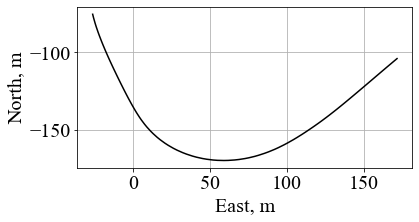

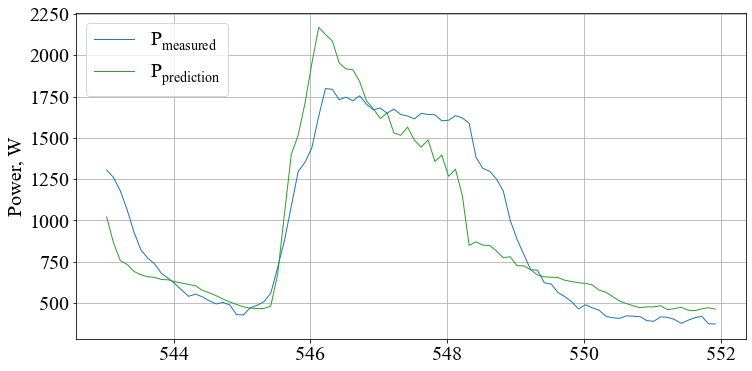

In [39]:
as_ranges = [[120, 180], [208, 300], [380, 420], [540, 580], [460, 520]]
as_rangesb = [[50, 100], [160, 220], [280, 340]]
plot_ne_data(data.loc[as_ranges[3][0]+3:as_ranges[3][0]+12])
saveplot('performance_test_extract_xy')
plot_performance_data(data.loc[as_ranges[3][0]+3:as_ranges[3][0]+12])
saveplot('performance_test_extract_results')

In [9]:



def performance_simple(data, asranges):
    lev_data = data.loc[data['attitude_roll'] < math.radians(45)]
    level_data = lev_data.loc[lev_data['attitude_roll'] > -math.radians(45)]

    ave_values = []
    for as_range in asranges:
        ave_values.append(level_data[['power', 'airspeed', 'prediction']].loc[as_range[0]:as_range[1]].mean())

    return pd.DataFrame(ave_values)

average_performance = performance_simple(data, as_ranges).append(performance_simple(datab, as_rangesb))
average_performance

,power,airspeed,prediction
0,295.474766,17.732090,417.973467
1,393.393667,21.063695,377.345318
2,565.835375,23.693094,490.874155
3,589.623283,27.359206,562.942418
4,949.297059,30.918098,761.721733
0,256.075053,17.986935,396.430326
1,419.928740,22.173422,381.880497
2,630.968931,26.563619,480.317080


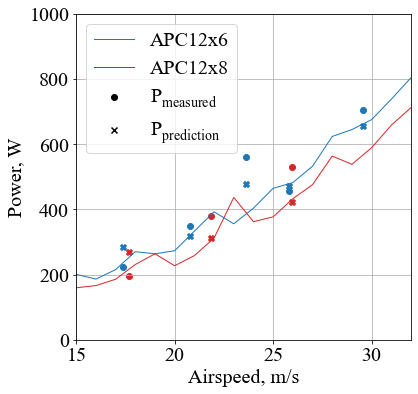

In [10]:
def performance_simple(datas, asranges):
    lev_data = datas.loc[datas['attitude_roll'] < math.radians(10)]
    level_data = lev_data.loc[lev_data['attitude_roll'] > -math.radians(10)]

    ave_values = []
    for as_range in asranges:
        ave_values.append(level_data[['power', 'airspeed', 'prediction']].loc[as_range[0]:as_range[1]].mean())

    return pd.DataFrame(ave_values)

#average_performance = performance_simple(data, as_ranges).append(performance_simple(datab, as_rangesb))
average_performance = performance_simple(data, as_ranges)
average_performance2 = performance_simple(datab, as_rangesb)

    
def prediction(prop, aircraft=buddita, bmass=base_mass):
    df = pd.DataFrame(range(15, 35), columns=['velocity_x'])
    df['acceleration_z'] = -9.81
    df['acceleration_x'] = 0
    df['velocity_y'] = 0
    df['velocity_z'] = 0
    df['wind_x'] = 0
    df['wind_y'] = 0
    df = generate_prediction(df, prop, aircraft, bmass)    
    return df

sl_12x6 = prediction(apc12x6)
sl_12x8 = prediction(apc12x8)

fig, ax = matplotplot()
lns=[]
lns.append(ax.scatter(average_performance['airspeed'],average_performance['power'], color='tab:blue', marker='o',  label = '$P_{test}$, APC12x6'))
lns.append(ax.scatter(average_performance['airspeed'],average_performance['prediction'], color='tab:blue', marker='X', label = '$P_{req}$, APC12x6'))

lns.append(ax.scatter(average_performance2['airspeed'],average_performance2['power'], color='tab:red', marker='o', label = '$P_{test}$, APC12x8'))
lns.append(ax.scatter(average_performance2['airspeed'],average_performance2['prediction'], color='tab:red', marker='X', label = '$P_{req}$, APC12x8'))

lnb=[]
lnb += ax.plot(sl_12x6['airspeed'], sl_12x6['prediction'], label ='APC12x6', color='tab:blue', linewidth=1)
lnb += ax.plot(sl_12x8['airspeed'], sl_12x8['prediction'], label ='APC12x8', color='tab:red', linewidth=1)
lnb.append(ax.scatter([0], [0], marker='o',  label = '$P_{measured}$', color='black'))
lnb.append(ax.scatter([0], [0], marker='x',  label = '$P_{prediction}$', color='black'))

#linesc = ax.scatter(average_performance2.index.values,average_performance2[['power']])
#linesd = ax.scatter(average_performance2.index.values,average_performance2[['prediction']])
ax.set_xlim(15,32)
ax.set_ylim(0,1000)
ax.legend(lnb, [l.get_label() for l in lnb], loc=2)
#ax.legend(lnb, [l.get_label() for l in lnb], loc=4)
ax.set_xlabel('Airspeed, m/s')
ax.set_ylabel('Power, W')
ax.grid()
saveplot('buddita_performance_predictions')

In [11]:
buddi = DesignPoint().copy()
buddi.mass = 11.66
#buddi.mass = buddi.mass - 3.208
bmass = buddi.mass
buddi.Capacity = buddi.Capacity * 0.5
apc20x13 = APCProp('PER3_20x13E')
buddi.cd0 =  0.03
buddi.profiledrag = 0.0078
buddi.clmax = 1.3
buddi.pe = 0.325


buddi_sea_level = prediction(apc20x13, buddi, bmass)

buddi_altitude = DesignPoint().copy()
buddi_altitude.cd0 =  0.03
buddi_altitude.profiledrag = 0.0078
buddi_altitude.clmax = 1.3
buddi_altitude.pe = 0.325

buddi_altitude.rho = 0.7364
buddi_altitude.mass = 11.66
bmass = buddi_altitude.mass
buddi_altitude.Capacity = buddi_altitude.Capacity * 0.5
buddi_alt = prediction(apc20x13, buddi_altitude, bmass)


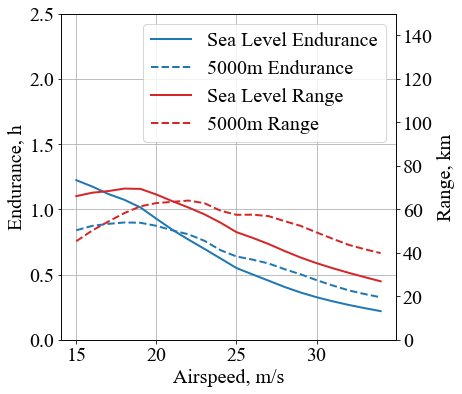

In [12]:

fig, ax = matplotplot()

lns=[]
lns += ax.plot(buddi_sea_level['airspeed'], buddi_sea_level['endurance'] / (60 * 60), label ='Sea Level Endurance', color='tab:blue', linewidth=2)
lns += ax.plot(buddi_alt['airspeed'], buddi_alt['endurance'] / (60 * 60), label ='5000m Endurance', color='tab:blue', linewidth=2, linestyle = '--')

ax2 = ax.twinx()
lns += ax2.plot(buddi_sea_level['airspeed'], buddi_sea_level['range'] / 1000, label ='Sea Level Range', color='tab:red', linewidth=2)
lns += ax2.plot(buddi_alt['airspeed'], buddi_alt['range'] / 1000, label ='5000m Range', color='tab:red', linewidth=2, linestyle = '--')

ax2.set_ylabel('Range, km')
rspine = ax2.spines['right']
rspine.set_position(('axes', 1))

ax.legend(lns, [l.get_label() for l in lns], loc=1)
#ax.legend(lnb, [l.get_label() for l in lnb], loc=4)
ax.set_xlabel('Airspeed, m/s')
ax.set_ylabel('Endurance, h')
ax.set_ylim(0,2.5)
ax2.set_ylim(0,150)
ax.grid()
saveplot('buddi_performance_predictions_vtol_to')


In [13]:
buddi_heavy = buddi.copy()
buddi_heavy.mass = 11.66 + 3.208
bmass = buddi_heavy.mass
print(buddi_heavy.mass, buddi_heavy.rho, buddi_heavy.S, buddi_heavy.clmax)

buddi_heavy.Capacity = buddi_heavy.Capacity * 2

apc20x13 = APCProp('PER3_20x13E')

buddi_heavy_sea_level = prediction(apc20x13, buddi_heavy, bmass)

buddi_heavy_altitude = buddi_heavy.copy()
buddi_heavy_altitude.rho = 0.7364
buddi_heavy_alt = prediction(apc20x13, buddi_heavy_altitude, bmass)

print(buddi_heavy.mass, buddi_heavy.rho, buddi_heavy.S, buddi_heavy.clmax)

print(buddi_heavy_altitude.stall_speed, buddi_heavy.stall_speed, buddi.stall_speed, buddi_altitude.stall_speed)


14.868 1.225 0.6823375 1.3
14.868 1.225 0.6823375 1.3
21.13234010784475 16.384622406428576 14.509733514061407 18.714170878483813


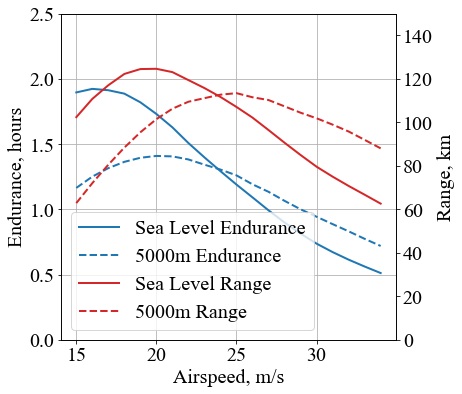

In [14]:
fig, ax = matplotplot()

lns=[]
lns += ax.plot(buddi_heavy_sea_level['airspeed'], buddi_heavy_sea_level['endurance'] / (60 * 60), label ='Sea Level Endurance', color='tab:blue', linewidth=2)
lns += ax.plot(buddi_heavy_alt['airspeed'], buddi_heavy_alt['endurance'] / (60 * 60), label ='5000m Endurance', color='tab:blue', linewidth=2, linestyle = '--')

ax2 = ax.twinx()
lns += ax2.plot(buddi_heavy_sea_level['airspeed'], buddi_heavy_sea_level['range'] / 1000, label ='Sea Level Range', color='tab:red', linewidth=2)
lns += ax2.plot(buddi_heavy_alt['airspeed'], buddi_heavy_alt['range'] / 1000, label ='5000m Range', color='tab:red', linewidth=2, linestyle = '--')

ax2.set_ylabel('Range, km')
rspine = ax2.spines['right']
rspine.set_position(('axes', 1))

ax.legend(lns, [l.get_label() for l in lns], loc=3)
#ax.legend(lnb, [l.get_label() for l in lnb], loc=4)
ax.set_xlabel('Airspeed, m/s')
ax.set_ylabel('Endurance, hours')
ax.set_ylim(0,2.5)
ax2.set_ylim(0,150)
ax.grid()
saveplot('buddi_performance_predictions_stol_to')

In [15]:

def sizing_buddis(U, rho, mass_offset):
    scaled_buddis = []
    for w in range(22, 33):
        scaled_buddi = DesignPoint().copy()
        scaled_buddi.w = w/10
        scaled_buddi.Capacity = 61200
        scaled_buddi.S = 0.1009375*scaled_buddi.w**2
        scaled_buddi.mass = 7.2 + 2.133 * (scaled_buddi.w / 2.6) + 1.133 * (scaled_buddi.w / 2.6) ** 2 + 0.533 * (scaled_buddi.w / 2.6) ** 3 + mass_offset
        scaled_buddi.U = U
        scaled_buddi.rho = rho
        scaled_buddis.append(scaled_buddi.to_dict())

    return pd.DataFrame(scaled_buddis).loc[:,['w', 'S', 'mass', 'U', 'rho', 'stall_speed', 'is_stalled', 'power', 'endurance', 'range']].set_index('w')

scaled_buddis_sl_20 = sizing_buddis(20, 1.225, 0)
scaled_buddis_alt_20 = sizing_buddis(20, 0.7364, 0)
scaled_buddis_sl_20_heavy = sizing_buddis(20, 1.225, 4)
scaled_buddis_alt_20_heavy = sizing_buddis(20, 0.7364, 4)
scaled_buddis_sl_25 = sizing_buddis(25, 1.225, 0)
scaled_buddis_alt_25 = sizing_buddis(25, 0.7364, 0)
scaled_buddis_sl_25_heavy = sizing_buddis(25, 1.225, 4)
scaled_buddis_alt_25_heavy = sizing_buddis(25, 0.7364, 4)


In [18]:


def concat_scaling_data(targets, dfs):
    keepdfs = []
    for key, df in dfs.items():
        keepdf = df.loc[:,targets]
        keepdf.columns = [key + '_' + column for column in keepdf.columns.to_list()]
        keepdfs.append(keepdf)
    
    return pd.concat(keepdfs, axis=1)

scaling_data = concat_scaling_data(
    ['mass', 'endurance', 'range', 'stall_speed'], 
    {
        'sl_20': scaled_buddis_sl_20, 
        'alt_20': scaled_buddis_alt_20,
        'sl_20_heavy': scaled_buddis_sl_20_heavy,
        'alt_20_heavy': scaled_buddis_alt_20_heavy,
        'sl_25': scaled_buddis_sl_25, 
        'alt_25': scaled_buddis_alt_25,
        'sl_25_heavy': scaled_buddis_sl_25_heavy,
        'alt_25_heavy': scaled_buddis_alt_25_heavy,
    }
     )

scaling_data

,sl_20_mass,sl_20_endurance,sl_20_range,sl_20_stall_speed,alt_20_mass,alt_20_endurance,alt_20_range,alt_20_stall_speed,sl_20_heavy_mass,sl_20_heavy_endurance,...,alt_25_range,alt_25_stall_speed,sl_25_heavy_mass,sl_25_heavy_endurance,sl_25_heavy_range,sl_25_heavy_stall_speed,alt_25_heavy_mass,alt_25_heavy_endurance,alt_25_heavy_range,alt_25_heavy_stall_speed
w,,,,,,,,,,,,,,,,,,,,,
2.2,10.138953,3994.034094,79880.681872,15.990328,10.138953,0.000000,0.000000,20.623792,14.138953,2492.553269,...,66751.490777,20.623792,14.138953,1958.990851,48974.771287,18.882933,14.138953,1778.997112,44474.927797,24.354578
2.3,10.342477,3905.387363,78107.747251,15.447847,10.342477,3422.225499,68444.509977,19.924118,14.342477,2523.619574,...,65696.165682,19.924118,14.342477,1919.510718,47987.767948,18.191468,14.342477,1809.437852,45235.946309,23.462750
2.4,10.553538,3797.844602,75956.892037,14.954480,10.553538,3451.488656,69029.773127,19.287790,14.553538,2535.492041,...,64316.727652,19.287790,14.553538,1871.710397,46792.759937,17.561296,14.553538,1826.531696,45663.292393,22.649975
2.5,10.772319,3676.618259,73532.365178,14.504344,10.772319,3460.209250,69204.184996,18.707220,14.772319,2530.007560,...,62689.854904,18.707220,14.772319,1803.742825,45093.570615,16.985089,14.772319,1831.284542,45782.113543,21.906802
2.6,10.999000,3546.210457,70924.209142,14.092458,10.999000,3450.401011,69008.020229,18.175983,14.999000,2509.259025,...,60883.888191,18.175983,14.999000,1731.700292,43292.507289,16.456645,14.999000,1824.927478,45623.186952,21.225233
2.7,11.233764,3410.384383,68207.687669,13.714576,11.233764,3424.245734,68484.914682,17.688604,15.233764,2475.449681,...,58957.716338,17.688604,15.233764,1657.619383,41440.484569,15.970678,15.233764,1808.821885,45220.547129,20.598449
2.8,11.476793,3272.194539,65443.890786,13.367055,11.476793,3383.980636,67679.612729,17.240383,15.476793,2430.773958,...,56960.623228,17.240383,15.476793,1583.108276,39577.706894,15.522654,15.476793,1784.376901,44609.422525,20.020601
2.9,11.728268,3134.052040,62681.040793,13.046754,11.728268,3331.807626,66636.152530,16.827268,15.728268,2377.327562,...,54932.776587,16.827268,15.728268,1509.396842,37734.921050,15.108661,15.728268,1752.982753,43824.568837,19.486647
3.0,11.988373,2997.806914,59956.138273,12.750945,11.988373,3269.824985,65396.499704,16.445744,15.988373,2317.045746,...,52906.094558,16.445744,15.988373,1437.393931,35934.848265,14.725308,15.988373,1715.960891,42899.022272,18.992212


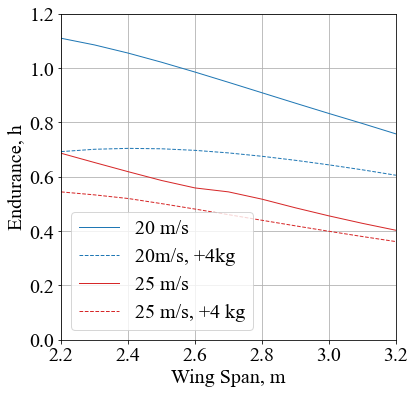

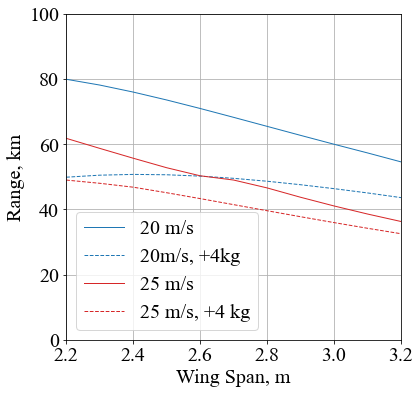

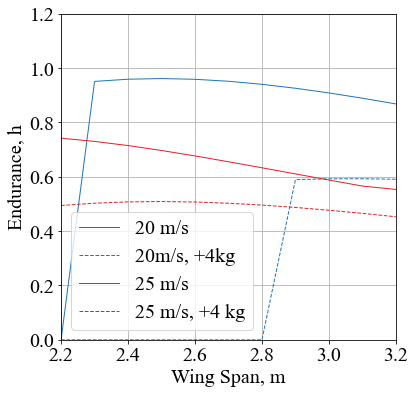

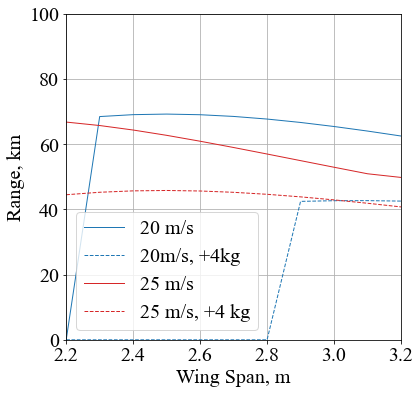

In [19]:

def plot_scaling(alt, target, factor, title, ymin=0, ymax=None):
    fig, ax = matplotplot()
    
    
    lns=[]
    lns += ax.plot(scaling_data[alt + '_20_' + target] * factor, label ='20 m/s', color='tab:blue', linewidth=1)
    lns += ax.plot(scaling_data[alt + '_20_heavy_' + target] * factor, label ='20m/s, +4kg', color='tab:blue', linewidth=1, linestyle = '--')

    lns += ax.plot(scaling_data[alt + '_25_' + target] * factor, label ='25 m/s', color='tab:red', linewidth=1)
    lns += ax.plot(scaling_data[alt + '_25_heavy_' + target] * factor, label ='25 m/s, +4 kg', color='tab:red', linewidth=1, linestyle = '--')

    ax.legend(lns, [l.get_label() for l in lns], loc=3)
    #ax.legend(lnb, [l.get_label() for l in lnb], loc=4)
    ax.set_xlabel('Wing Span, m')
    ax.set_ylabel(title)
    if ymax:
        ax.set_ylim(ymin,ymax)
    ax.set_xlim(2.2,3.2)
    ax.grid()

plot_scaling('sl', 'endurance', 1 / (60 * 60),  'Endurance, h', 0, 1.2)
saveplot('buddi_sizing_sl_endurance')
plot_scaling('sl', 'range', 1/1000, 'Range, km' ,0, 100)
saveplot('buddi_sizing_sl_range')
plot_scaling('alt', 'endurance', 1 / (60 * 60),  'Endurance, h', 0, 1.2)
saveplot('buddi_sizing_alt_endurance')
plot_scaling('alt', 'range', 1/1000, 'Range, km' ,0, 100)
saveplot('buddi_sizing_alt_range')




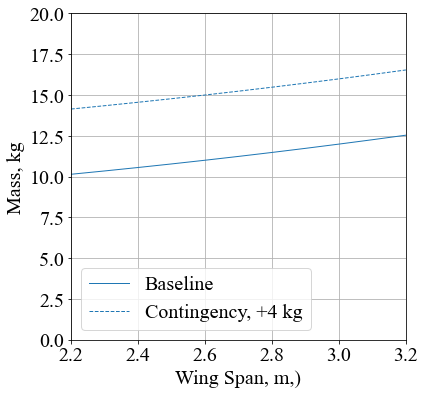

In [20]:
fig, ax = matplotplot()
lns=[]
lns += ax.plot(scaling_data['sl_20_mass'] , label ='Baseline', color='tab:blue', linewidth=1)
lns += ax.plot(scaling_data['sl_20_heavy_mass'] , label ='Contingency, +4 kg', color='tab:blue', linewidth=1, linestyle = '--')

ax.legend(lns, [l.get_label() for l in lns], loc=3)
#ax.legend(lnb, [l.get_label() for l in lnb], loc=4)
ax.set_xlabel('Wing Span, m,)')
ax.set_ylabel('Mass, kg')
ax.set_xlim(2.2,3.2)
ax.set_ylim(0,20)
ax.grid()
saveplot('buddi_sizing_mass')

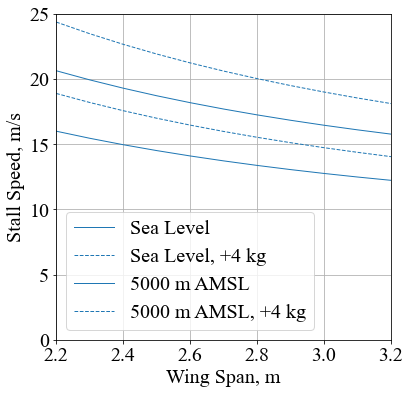

In [21]:
fig, ax = matplotplot()
lns=[]
lns += ax.plot(scaling_data['sl_20_stall_speed'] , label ='Sea Level', color='tab:blue', linewidth=1)
lns += ax.plot(scaling_data['sl_20_heavy_stall_speed'] , label ='Sea Level, +4 kg', color='tab:blue', linewidth=1, linestyle = '--')
lns += ax.plot(scaling_data['alt_20_stall_speed'] , label ='5000 m AMSL', color='tab:blue', linewidth=1)
lns += ax.plot(scaling_data['alt_20_heavy_stall_speed'] , label ='5000 m AMSL, +4 kg', color='tab:blue', linewidth=1, linestyle = '--')

ax.legend(lns, [l.get_label() for l in lns], loc=3)
#ax.legend(lnb, [l.get_label() for l in lnb], loc=4)
ax.set_xlabel('Wing Span, m')
ax.set_ylabel('Stall Speed, m/s')
ax.set_xlim(2.2,3.2)
ax.set_ylim(0,25)
ax.grid()
saveplot('buddi_sizing_stall_speed')

In [22]:
loghover = Flight.from_log('./performance_Data/2020_01_22/00000089.BIN')



In [23]:
hdata = extract_performance_data(loghover, APCProp('PER3_12x6.dat'), buddita)
hoverdata = hdata.loc[(hdata.mode_1==18) & (hdata.mode_0==18) & (hdata.power>100) & (hdata.airspeed_0 < 5)]
hoverdata.power.mean()


654.199433871443

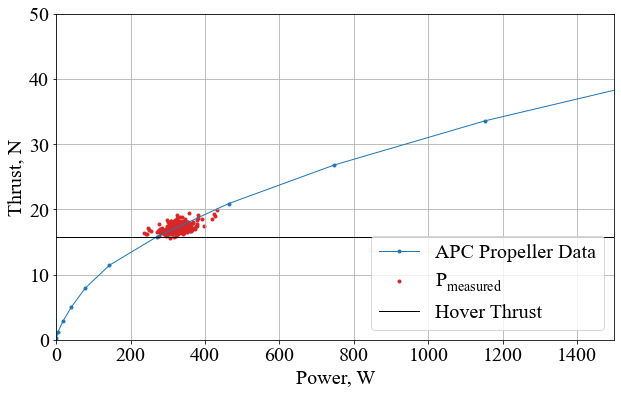

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

onehover = hoverdata[300:350]

prop_data = APCProp('PER3_12x6.dat')

dataIwant = prop_data.performance['V'] == 0

# expected power consumption based on steady level flight - hovering Throttle = W/2 (per motor)
weight = buddita.mass * 9.81

# plot
fig = plt.figure(figsize = (10, 6))
ax = plt.axes()

lns = []
lns += ax.plot(prop_data.performance[dataIwant].PWR, prop_data.performance[dataIwant].Thrust, label = 'APC Propeller Data', color='tab:blue', linewidth=1, marker=".")

lns.append(ax.scatter(onehover.power/2, onehover['thrust']/2, label = '$P_{measured}$', color='tab:red', marker="."))

lns += [ax.axhline(weight / 2, 0, 100, label = 'Hover Thrust', linewidth=1, color='black')]
#lns += [ax.axhline((weight + 3.445*9.81) / 2, 0, 100, label = 'STOL Hover Thrust', linewidth=1, color='black', linestyle='--')]
#lns += [ax.axvline(2800, 0, 100, label = '$P_{max}$', linewidth=1, color='black', linestyle='-.')]

ax.grid('both')
ax.legend(lns, [l.get_label() for l in lns], loc=4)
ax.set_xlabel('Power, W')
ax.set_ylabel('Thrust, N')
ax.set_xlim(0, 1500)
ax.set_ylim(0, 50)

plt.xticks(visible=True)
plt.yticks(visible=True)

plt.draw()

saveplot('buddita_hover_power')

In [25]:
hoverdata.columns


Index(['battery_0', 'battery_1', 'current_0', 'current_1', 'current_2',
       'current_3', 'airspeed_0', 'airspeed_1', 'position_x', 'position_y',
       'position_z', 'velocity_x', 'velocity_y', 'velocity_z',
       'acceleration_x', 'acceleration_y', 'acceleration_z', 'servos_0',
       'servos_1', 'servos_2', 'servos_3', 'servos_4', 'servos_5', 'servos_6',
       'servos_7', 'attitude_roll', 'attitude_pitch', 'attitude_yaw', 'wind_x',
       'wind_y', 'mode_0', 'mode_1', 'mode_2', 'power', 'airspeed', 'thrust',
       'pe', 'prediction', 'endurance', 'range'],
      dtype='object')

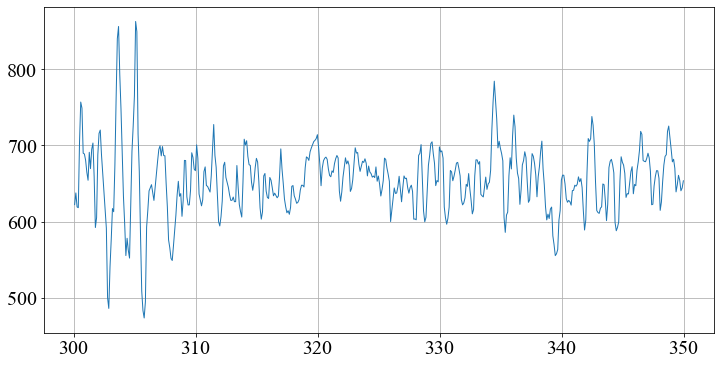

In [26]:
fig, ax = matplotplot(12)
onehover = hoverdata[300:350]
lns=[]
lns += ax.plot(onehover.power , label ='Sea Level', color='tab:blue', linewidth=1)

ax.grid()
saveplot('buddi_sizing_stall_speed')

In [27]:
buddi_prop = APCProp('PER3_20x13E')

buddi_prop.performance[buddi_prop.performance.V ==0]

,rpm,V,J,Pe,Ct,Cp,PWR,Torque,Thrust
0,1000,0.0,0.0,0.0,0.0936,0.0407,7.456999,0.074570,2.121802
30,2000,0.0,0.0,0.0,0.0935,0.0391,60.401690,0.286868,8.478310
60,3000,0.0,0.0,0.0,0.0940,0.0429,222.218562,0.707511,19.171835
90,4000,0.0,0.0,0.0,0.0969,0.0719,883.654348,2.109314,35.163192
120,5000,0.0,0.0,0.0,0.0995,0.0977,2344.480396,4.477363,56.399002
150,6000,0.0,0.0,0.0,0.0996,0.0995,4127.448789,6.569164,81.317939
180,7000,0.0,0.0,0.0,0.0970,0.0721,4750.108182,6.479906,107.771513
210,8000,0.0,0.0,0.0,0.0945,0.0434,4269.877465,5.097085,137.085294
240,9000,0.0,0.0,0.0,0.0940,0.0391,5469.708558,5.803805,172.622136
270,10000,0.0,0.0,0.0,0.0946,0.0496,9524.824460,9.095618,214.511039


In [28]:

hover_power = buddi_prop.get_pwr(0, 0.5* scaling_data['sl_20_mass'].loc[2.6]*9.81) / 0.88
print('mass = ', scaling_data['sl_20_mass'].loc[2.6])
print('hover power = ', hover_power)
print('hover endurance = ',get_endurance( hover_power*2, buddi) / (60))
0.5* scaling_data['sl_20_mass'].loc[2.6]*9.81


mass =  10.999
hover power =  2472.7481824661477
hover endurance =  4.110780014010243


53.950095000000005

In [29]:
hover_power_heavy = buddi_prop.get_pwr(0, 0.5* scaling_data['sl_20_heavy_mass'].loc[2.6]*9.81) / 0.88
print('mass = ', scaling_data['sl_20_heavy_mass'].loc[2.6])
print('hover power = ', hover_power_heavy)
print('hover endurance = ',get_endurance( hover_power_heavy*2, buddi) / (60))
0.5* scaling_data['sl_20_heavy_mass'].loc[2.6]*9.81

mass =  14.999
hover power =  4060.3236366380243
hover endurance =  2.157392916201977


73.57009500000001

In [30]:
hover_power_less_battery = buddi_prop.get_pwr(0, 0.5* (scaling_data['sl_20_mass'].loc[2.6]-3.208)*9.81) / 0.88
print('mass = ', scaling_data['sl_20_mass'].loc[2.6]-3.208)
print('hover power = ', hover_power_less_battery)
print('hover endurance = ',get_endurance( hover_power_less_battery*2, buddi) / (60))

mass =  7.791
hover power =  1242.7049591775012
hover endurance =  10.054943954524838


In [31]:
hover_power_less_battery = buddi_prop.get_pwr(0, 0.5*(11.66+ 3.445)*9.81) #/ 0.88
print('mass = ', 11+3.445)
print('thrust per motor = ', 0.5*(11.66)*9.81, 'N')
print('hover power = ', hover_power_less_battery*2)
print('hover endurance = ',get_endurance( hover_power_less_battery*2, buddi) / (60))

mass =  14.445
thrust per motor =  57.1923 N
hover power =  7220.57235196211
hover endurance =  2.5133558281445527


In [32]:
log_folder

'./performance_Data/2019_12_17 performance vtol testing'

In [33]:
logben = Flight.from_log('./performance_Data/12.BIN')

In [36]:
from scipy import integrate


df_rho = pd.DataFrame(
    [[-2000,1.4782075],
    [-1500,1.411445],
    [-1000,1.34701],
    [-500,1.2849025],
    [0,1.225],
    [500,1.1673025],
    [1000,1.1116875],
    [1500,1.058155],
    [2000,1.0065825],
    [2500,0.95697],
    [3000,0.9093175],
    [3500,0.86338],
    [4000,0.8194025],
    [4500,0.7770175],
    [5000,0.73647],
    [5500,0.697515],
    [6000,0.6601525],
    [6500,0.62426],
    [7000,0.5900825],
    [7500,0.5572525],
    [8000,0.52577],
    [8500,0.4957575],
    [9000,0.4670925],
    [9500,0.4396525],
    [10000,0.41356],
    [10500,0.38857],
    [11000,0.364805],
    [11500,0.3374875],
    [12000,0.311885],
    [12500,0.288365],
    [13000,0.26656],
    [13500,0.24647],
    [14000,0.22785],
    [14500,0.2107],
    [15000,0.194775],
    [15500,0.180075],
    [16000,0.1664775],
    [16500,0.15386],
    [17000,0.142345],
    [17500,0.131565],
    [18000,0.1216425],
    [18500,0.1124795],
    [19000,0.10399025],
    [19500,0.0961625],
    [20000,0.0889105],
    [22000,0.0645085],
    [24000,0.046942],
    [26000,0.03426325],
    [28000,0.02507575],
    [30000,0.01841175],
    ],
    columns=['h', 'rho']
)

from scipy.interpolate import interp1d

rho = interp1d(df_rho.h, df_rho.rho)
rho(3000)

array(0.9093175)

In [37]:
from scipy import integrate

def get_thrust2(U, accx, accz, h, aircraft=buddi, bmass=base_mass):
    aircraft.U = U
    aircraft.rho = rho(h) 
    aircraft.mass = bmass * accz / 9.81
    drag_force = aircraft.q * aircraft.S * aircraft.cd
    acc_x_force = accx * bmass
    if acc_x_force < 0:
        acc_x_force=0
    return drag_force + acc_x_force    

def get_power(U, thrust, pe):
    return thrust * U / pe


databen = logben.read_fields([Fields.BATTERY, Fields.CURRENT, Fields.AIRSPEED, Fields.POSITION, Fields.VELOCITY, Fields.ACCELERATION, Fields.SERVOS, Fields.ATTITUDE, Fields.SENSORALTITUDE])

databen['rho'] = rho(databen['altitude_baro'])
databen = databen.loc[(pd.isna(databen['airspeed_0'])==False) & (databen['airspeed_0']>10)]
databen['acceleration_z'] = -databen['acceleration_z']
databen['power'] = databen['battery_0'] * databen['current_0'] * 2
databen.acceleration_x = databen.acceleration_x - databen.acceleration_x.mean()
databen['thrust'] = np.vectorize(get_thrust2)(databen['airspeed_0'], databen['acceleration_x'], databen['acceleration_z'],databen['rho'], buddi, 11.0)

databen['pe'] = apc20x13.get_pe(np.array(databen['airspeed_0']), 0.5 * np.array(databen['thrust']))

databen['pe'].loc[databen['pe']<0.1] = 0.1
databen['pe'] = databen['pe'] * buddi.pe
databen['prediction'] = np.vectorize(get_power)(databen['airspeed_0'], databen['thrust'], databen['pe'])
databen['consumption_prediction'] = integrate.cumtrapz(np.array(databen.prediction), databen.index, initial=0)
databen = filterdata(databen)
databen.index = databen.index / 60

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:

fig, ax = matplotplot(12,6)
ax3 = ax.twinx()

ax4 = ax.twinx()

lns=[]
lns += ax.plot(databen['filter_airspeed'],  linewidth=1, color='tab:blue', label = 'U')
ax.set_ylabel('Airspeed, m/s')


lns += ax3.plot(databen['ekf_position_z'],  linewidth=1, color='tab:orange', label = 'Altitude')
ax3.set_ylabel('Altitude, m')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.13))


lns += ax4.plot(100*databen['consumption_prediction'] / (buddi.Capacity * buddi.Voltage), linewidth=2, color='tab:red', label = 'Battery Used')
ax4.set_ylabel('Consumption, %')
ax4.grid()
ax4.set_ylim(0, 150)
rspine = ax4.spines['right']
rspine.set_position(('axes', 1))
ax.set_xlabel('Time, minutes')
ax.legend(lns, [l.get_label() for l in lns], loc=2)
saveplot('buddi_vtol_guatemala_mission')

In [ ]:

databen2 = logben.read_fields([Fields.BATTERY, Fields.CURRENT, Fields.AIRSPEED, Fields.EKFPOSITION, Fields.VELOCITY, Fields.ACCELERATION, Fields.SERVOS, Fields.ATTITUDE, Fields.SENSORALTITUDE])
databen2.acceleration_x = databen2.acceleration_x - databen2.acceleration_x.mean()
databen2['rho'] = rho(databen2['altitude_baro'])
databen2 = databen2.loc[(pd.isna(databen2['airspeed_0'])==False) & (databen2['airspeed_0']>10)]
databen2['acceleration_z'] = -databen2['acceleration_z']
databen2['power'] = databen2['battery_0'] * databen2['current_0'] * 2

databen2['thrust'] = np.vectorize(get_thrust2)(databen2['airspeed_0'], databen2['acceleration_x'], databen2['acceleration_z'],databen2['rho'], buddi_heavy, 14.2)

databen2['pe'] = apc20x13.get_pe(np.array(databen2['airspeed_0']), 0.5 * np.array(databen2['thrust']))

databen2['pe'].loc[databen2['pe']<0.1] = 0.1
databen2['pe'] = databen2['pe'] * buddi_heavy.pe
databen2['prediction'] = np.vectorize(get_power)(databen2['airspeed_0'], databen2['thrust'], databen2['pe'])
databen2['consumption_prediction'] = integrate.cumtrapz(np.array(databen2.prediction), databen2.index, initial=0)
databen2 = filterdata(databen2)
databen2.index = databen2.index / 60

In [ ]:

fig, ax = matplotplot(12,6)

ax3 = ax.twinx()
ax4 = ax.twinx()

lns=[]
lns += ax.plot(databen2['filter_airspeed'],  linewidth=1, color='tab:blue', label = 'U')
ax.set_ylabel('Airspeed, m/s')


lns += ax3.plot(databen2['ekf_position_z'],  linewidth=1, color='tab:orange', label = 'Altitude')
ax3.set_ylabel('Altitude, m')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.13))


lns += ax4.plot(100*databen2['consumption_prediction'] / (buddi_heavy.Capacity * buddi_heavy.Voltage), linewidth=2, color='tab:red', label = 'STOL Consumption')
ax4.set_ylabel('Consumption, %')

lns += ax4.plot(100*databen['consumption_prediction'] / (buddi.Capacity * buddi.Voltage), linewidth=2, color='tab:red', label = 'VTOL Consumption', linestyle = '--')
ax4.set_ylabel('Consumption, %')

ax4.set_ylim(0, 150)
ax.set_xlabel('Time, minutes')
rspine = ax4.spines['right']
ax4.grid()
rspine.set_position(('axes', 1.0))

ax.legend(lns, [l.get_label() for l in lns], loc=2)
saveplot('buddi_guatemala_mission')

In [ ]:
4.75*60

In [ ]:
20*100/285